# Semantic_Human_Matting
The project is my reimplement of paper ([Semantatic Human Matting](https://arxiv.org/abs/1809.01354)) from Alibaba,  it proposes a new end-to-end scheme to predict human alpha from image. SHM is the first algorithm that learns to jointly fit both semantic information and high quality details with deep networks. 

One of the main contributions of the paper is that: ***A large scale high quality human matting dataset is created. It contains 35,513 unique human images with corresponding alpha mattes***. But, the dataset is not avaiable. 

# Download dataset


In [1]:
# ! gdown --id 1ZrKzesAbM6o_PbTATRrSLUej5VHxaAaT
#from google.colab import drive
#drive.mount('/content/drive')

## P3M

In [20]:
! gdown --id 1Obz8faAgE52yASpdUwKqxA8pn5gmizhT

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Obz8faAgE52yASpdUwKqxA8pn5gmizhT
To: /content/P3M-500-P.zip
100% 297M/297M [00:01<00:00, 206MB/s]


In [21]:
!unzip /content/P3M-500-P.zip

Archive:  /content/P3M-500-P.zip
  inflating: P3M-500-P/P3M-50-P_list.txt  
  inflating: P3M-500-P/P3M-450-P_list.txt  
  inflating: P3M-500-P/P3M-last-50-P_list.txt  
  inflating: P3M-500-P/train_set.txt  
   creating: P3M-500-P/.ipynb_checkpoints/
  inflating: P3M-500-P/trimap/p_d6e8e99f.png  
  inflating: P3M-500-P/trimap/p_f2473eb4.png  
  inflating: P3M-500-P/trimap/p_116d90a9.png  
  inflating: P3M-500-P/trimap/p_6a4b3cae.png  
  inflating: P3M-500-P/trimap/p_04515010.png  
  inflating: P3M-500-P/trimap/p_b83de135.png  
  inflating: P3M-500-P/trimap/p_51c916fc.png  
  inflating: P3M-500-P/trimap/p_720a374f.png  
  inflating: P3M-500-P/trimap/p_e0419de5.png  
  inflating: P3M-500-P/trimap/p_10e1fdee.png  
  inflating: P3M-500-P/trimap/p_65ad429f.png  
  inflating: P3M-500-P/trimap/p_cdadbbec.png  
  inflating: P3M-500-P/trimap/p_e800c7b3.png  
  inflating: P3M-500-P/trimap/p_f0af7ee5.png  
  inflating: P3M-500-P/trimap/p_ebe9520a.png  
  inflating: P3M-500-P/trimap/p_41898f08.png 

## Animal Matting

In [4]:
! gdown --id 1JLLurcABqV21HN_RWaEj7n4aSD9wAxfX
! gdown --id 19eIIrK3IKZj3oMTG-laThScIXRiQPklH

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1JLLurcABqV21HN_RWaEj7n4aSD9wAxfX
To: /content/AM_list.txt
100% 2.40k/2.40k [00:00<00:00, 2.96MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19eIIrK3IKZj3oMTG-laThScIXRiQPklH
To: /content/AM.zip
100% 145M/145M [00:01<00:00, 120MB/s]


In [96]:
!unzip /content/AM.zip

Archive:  /content/AM.zip
  inflating: validation/original/m_7e875215.jpg  
  inflating: validation/original/m_db536939.jpg  
  inflating: validation/original/m_bea1ea30.jpg  
  inflating: validation/original/m_24f6a794.jpg  
replace validation/trimap/m_63795be1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: validation/trimap/m_63795be1.png  
  inflating: validation/original/m_07187cc8.jpg  
  inflating: validation/original/m_bfd31c85.jpg  
  inflating: validation/original/m_a0d5d958.jpg  
  inflating: validation/original/m_f4b09516.jpg  
replace validation/trimap/m_a2a695bb.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: validation/trimap/m_a2a695bb.png  
replace validation/trimap/m_9593f06b.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
# !ln -s /content/validation/ AM


# Import Modules

Import debugging package

In [7]:
import argparse
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import os
import torch.nn.functional as F

import cv2
import random as r
import numpy as np


# Load and process the data

In [23]:
 
def read_files(data_dir, file_name={}):
    image_name = os.path.join(data_dir, 'image', file_name['image'])
    trimap_name = os.path.join(data_dir, 'trimap', file_name['trimap'])
    alpha_name = os.path.join(data_dir, 'alpha', file_name['alpha'])
    image = cv2.imread(image_name)
    trimap = cv2.imread(trimap_name)
    alpha = cv2.imread(alpha_name)

    return image, trimap, alpha


def random_scale_and_creat_patch(image, trimap, alpha, patch_size):
    # random scale
    if r.random() < 0.5:
        h, w, c = image.shape
        scale = 0.75 + 0.5*r.random()
        image = cv2.resize(image, (int(w*scale),int(h*scale)), interpolation=cv2.INTER_CUBIC)
        trimap = cv2.resize(trimap, (int(w*scale),int(h*scale)), interpolation=cv2.INTER_NEAREST)
        alpha = cv2.resize(alpha, (int(w*scale),int(h*scale)), interpolation=cv2.INTER_CUBIC)    
    # creat patch
    if r.random() < 0.5:
        h, w, c = image.shape
        
        if h > patch_size and w > patch_size:
            x = r.randrange(0, w - patch_size)
            y = r.randrange(0, h - patch_size)
            image = image[y:y + patch_size, x:x+patch_size, :]
            trimap = trimap[y:y + patch_size, x:x+patch_size, :]
            alpha = alpha[y:y+patch_size, x:x+patch_size, :]
        else:
            image = cv2.resize(image, (patch_size,patch_size), interpolation=cv2.INTER_CUBIC)
            trimap = cv2.resize(trimap, (patch_size,patch_size), interpolation=cv2.INTER_NEAREST)
            alpha = cv2.resize(alpha, (patch_size,patch_size), interpolation=cv2.INTER_CUBIC)
    else:
        image = cv2.resize(image, (patch_size,patch_size), interpolation=cv2.INTER_CUBIC)
        
        trimap = cv2.resize(trimap, (patch_size,patch_size), interpolation=cv2.INTER_NEAREST)
        alpha = cv2.resize(alpha, (patch_size,patch_size), interpolation=cv2.INTER_CUBIC)

    return image, trimap, alpha


def random_flip(image, trimap, alpha):

    if r.random() < 0.5:
        image = cv2.flip(image, 0)
        trimap = cv2.flip(trimap, 0)
        alpha = cv2.flip(alpha, 0)

    if r.random() < 0.5:
        image = cv2.flip(image, 1)
        trimap = cv2.flip(trimap, 1)
        alpha = cv2.flip(alpha, 1)
    return image, trimap, alpha
       
def np2Tensor(array):
    ts = (2, 0, 1)
    tensor = torch.FloatTensor(array.transpose(ts).astype(float))    
    return tensor

class human_matting_data(DataLoader):
    """
    human_matting
    """

    def __init__(self, root_dir, imglist, patch_size):
        # super().__init__()
        self.data_root = root_dir

        self.patch_size = patch_size
        with open(imglist) as f:
            self.imgID = f.readlines()
        self.num = len(self.imgID)
        print("Dataset : file number %d"% self.num)




    def __getitem__(self, index):
        # read files
        image, trimap, alpha = read_files(self.data_root, 
                                          file_name={'image': self.imgID[index].strip() + '.jpg',
                                                     'trimap': self.imgID[index].strip() +'.png',
                                                     'alpha': self.imgID[index].strip() +'.png'})
        # cv2.imwrite(self.imgID[index].strip()+'.jpg', image)
        
         # NOTE ! ! !
        # trimap should be 3 classes : fg, bg. unsure
        trimap[trimap==0] = 0
        trimap[trimap==128] = 1
        trimap[trimap==255] = 2 

        # augmentation
        # image, trimap, alpha = random_scale_and_creat_patch(image, trimap, alpha, self.patch_size)
        # # cv2.imwrite(self.imgID[index].strip() + '2' + '.jpg', image)
        # image, trimap, alpha = random_flip(image, trimap, alpha)

        patch_size = self.patch_size
        image = cv2.resize(image, (patch_size,patch_size), interpolation=cv2.INTER_CUBIC)
        trimap = cv2.resize(trimap, (patch_size,patch_size), interpolation=cv2.INTER_NEAREST)
        alpha = cv2.resize(alpha, (patch_size,patch_size), interpolation=cv2.INTER_CUBIC)


        # normalize
        image = (image.astype(np.float32)  - (114., 121., 134.,)) / 255.0
        alpha = alpha.astype(np.float32) / 255.0
        # to tensor
        image = np2Tensor(image)
        trimap = np2Tensor(trimap)
        alpha = np2Tensor(alpha)

        trimap = trimap[0,:,:].unsqueeze_(0)
        alpha = alpha[0,:,:].unsqueeze_(0)
        
        sample = {'image': image, 'trimap': trimap, 'alpha': alpha}

        return sample

    def __len__(self):
        return self.num
# if __name__ == "__main__":
#      sample = human_matting_data(root_dir = "/content/drive/MyDrive/P3M-500-P", imglist = "/content/drive/MyDrive/P3M-500-P/P3M-50-P_list.txt", patch_size = 256)


# Helper Code

In [9]:
def set_lr(args, epoch, optimizer):

    lrDecay = args["lrDecay"]
    decayType = args["lrdecayType"]
    if decayType == 'keep':
        lr = args["lr"]
    elif decayType == 'step':
        epoch_iter = (epoch + 1) // lrDecay
        lr = args["lr"] / 2**epoch_iter
    elif decayType == 'exp':
        k = math.log(2) / lrDecay
        lr = args["lr"] * math.exp(-k * epoch)
    elif decayType == 'poly':
        lr = args["lr"] * math.pow((1 - epoch / args["nEpochs"]), 0.9)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr

# Build network

![SHM](https://github.com/lizhengwei1992/Semantic_Human_Matting/raw/master/network.png)


- ***Trimap generation: T-Net***


  The T-Net plays the role of semantic segmentation. I use mobilenet_v2+unet as T-Net to predict trimap.

- ***Matting network: M-Net***


  The M-Net aims to capture detail information and generate alpha matte. I build M-Net same as the paper, but reduce channels of the original net.
  
- ***Fusion Module***

  Probabilistic estimation of alpha matte can be written as <a href="https://www.codecogs.com/eqnedit.php?latex=\alpha&space;_{p}&space;=&space;F_{s}&space;&plus;&space;U_{s}\alpha&space;_{r}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\alpha&space;_{p}&space;=&space;F_{s}&space;&plus;&space;U_{s}\alpha&space;_{r}" title="\alpha _{p} = F_{s} + U_{s}\alpha _{r}" /></a>

## Trimap Generation: T-net

In [10]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        self.use_res_connect = self.stride == 1 and inp == oup

        self.conv = nn.Sequential(
            # pw
            nn.Conv2d(inp, inp * expand_ratio, 1, 1, 0, bias=False),
            nn.BatchNorm2d(inp * expand_ratio),
            nn.ReLU6(inplace=True),
            # dw
            nn.Conv2d(inp * expand_ratio, inp * expand_ratio, 3, stride, 1, groups=inp * expand_ratio, bias=False),
            nn.BatchNorm2d(inp * expand_ratio),
            nn.ReLU6(inplace=True),
            # pw-linear
            nn.Conv2d(inp * expand_ratio, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class mobilenet_v2(nn.Module):
    def __init__(self, nInputChannels=3):
        super(mobilenet_v2, self).__init__()
        # 1/2
        self.head_conv = nn.Sequential(nn.Conv2d(nInputChannels, 32, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        # 1/2
        self.block_1 = InvertedResidual(32, 16, 1, 1)
        # 1/4 
        self.block_2 = nn.Sequential( 
            InvertedResidual(16, 24, 2, 6),
            InvertedResidual(24, 24, 1, 6)
            )
        # 1/8 
        self.block_3 = nn.Sequential( 
            InvertedResidual(24, 32, 2, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 32, 1, 6)
            )
        # 1/16 
        self.block_4 = nn.Sequential( 
            InvertedResidual(32, 64, 2, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6)            
            )
        # 1/16
        self.block_5 = nn.Sequential( 
            InvertedResidual(64, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6)          
            )
        # 1/32 
        self.block_6 = nn.Sequential( 
            InvertedResidual(96, 160, 2, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 160, 1, 6)          
            )
        # 1/32
        self.block_7 = InvertedResidual(160, 320, 1, 6)

    def forward(self, x):
        x = self.head_conv(x)
        # 1/2
        s1 = self.block_1(x)
        # 1/4 
        s2 = self.block_2(s1)
        # 1/8
        s3 = self.block_3(s2)
        # 1/16
        s4 = self.block_4(s3)
        s4 = self.block_5(s4)
        # 1/32
        s5 = self.block_6(s4)
        s5 = self.block_7(s5)

        return s1, s2, s3, s4, s5


class T_mv2_unet(nn.Module):
    '''
        mmobilenet v2 + unet 
    '''

    def __init__(self, classes=3):

        super(T_mv2_unet, self).__init__()
        # -----------------------------------------------------------------
        # encoder  
        # ---------------------
        self.feature = mobilenet_v2()

        # -----------------------------------------------------------------
        # decoder 
        # ---------------------

        self.s5_up_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Conv2d(320, 96, 3, 1, 1),
                                        nn.BatchNorm2d(96),
                                        nn.ReLU())
        self.s4_fusion = nn.Sequential(nn.Conv2d(96, 96, 3, 1, 1),
                                       nn.BatchNorm2d(96))

        self.s4_up_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Conv2d(96, 32, 3, 1, 1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU())
        self.s3_fusion = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                       nn.BatchNorm2d(32))

        self.s3_up_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Conv2d(32, 24, 3, 1, 1),
                                        nn.BatchNorm2d(24),
                                        nn.ReLU())
        self.s2_fusion = nn.Sequential(nn.Conv2d(24, 24, 3, 1, 1),
                                       nn.BatchNorm2d(24))

        self.s2_up_conv = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Conv2d(24, 16, 3, 1, 1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU())
        self.s1_fusion = nn.Sequential(nn.Conv2d(16, 16, 3, 1, 1),
                                       nn.BatchNorm2d(16))

        self.last_conv = nn.Conv2d(16, classes, 3, 1, 1)
        self.last_up = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, input):

        # -----------------------------------------------
        # encoder 
        # ---------------------
        s1, s2, s3, s4, s5 = self.feature(input)
        # -----------------------------------------------
        # decoder
        # ---------------------
        s4_ = self.s5_up_conv(s5)
        s4_ = s4_ + s4
        s4 = self.s4_fusion(s4_)

        s3_ = self.s4_up_conv(s4)
        s3_ = s3_ + s3
        s3 = self.s3_fusion(s3_)

        s2_ = self.s3_up_conv(s3)
        s2_ = s2_ + s2
        s2 = self.s2_fusion(s2_)

        s1_ = self.s2_up_conv(s2)
        s1_ = s1_ + s1
        s1 = self.s1_fusion(s1_)

        out = self.last_conv(s1)

        return out

## Matting network: M-Net

In [11]:
class M_net(nn.Module):
    '''
        encoder + decoder
    '''

    def __init__(self, classes=2):

        super(M_net, self).__init__()
        # -----------------------------------------------------------------
        # encoder  
        # ---------------------
        # 1/2
        self.en_conv_bn_relu_1 = nn.Sequential(nn.Conv2d(6, 16, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU())
        self.max_pooling_1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 

        # 1/4
        self.en_conv_bn_relu_2 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.max_pooling_2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  

        # 1/8
        self.en_conv_bn_relu_3 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.max_pooling_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 

        # 1/16
        self.en_conv_bn_relu_4 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.max_pooling_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  

        self.en_conv_bn_relu_5 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        # -----------------------------------------------------------------
        # decoder  
        # ---------------------
        # 1/8
        self.de_conv_bn_relu_1 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.deconv_1 = nn.ConvTranspose2d(128, 128, 5, 2, 2, 1, bias=False)

        # 1/4
        self.de_conv_bn_relu_2 = nn.Sequential(nn.Conv2d(128, 64, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.deconv_2 = nn.ConvTranspose2d(64, 64, 5, 2, 2, 1, bias=False)

        # 1/2
        self.de_conv_bn_relu_3 = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.deconv_3 = nn.ConvTranspose2d(32, 32, 5, 2, 2, 1, bias=False)

        # 1/1
        self.de_conv_bn_relu_4 = nn.Sequential(nn.Conv2d(32, 16, 3, 1, 1, bias=False),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU())
        self.deconv_4 = nn.ConvTranspose2d(16, 16, 5, 2, 2, 1, bias=False)


        self.conv = nn.Conv2d(16, 1, 5, 1, 2, bias=False)


    def forward(self, input):

        # ----------------
        # encoder
        # --------
        x = self.en_conv_bn_relu_1(input)
        x = self.max_pooling_1(x)

        x = self.en_conv_bn_relu_2(x)
        x = self.max_pooling_2(x)

        x = self.en_conv_bn_relu_3(x)
        x = self.max_pooling_3(x)

        x = self.en_conv_bn_relu_4(x)
        x = self.max_pooling_4(x)
        # ----------------
        # decoder
        # --------
        x = self.de_conv_bn_relu_1(x)
        x = self.deconv_1(x)
        x = self.de_conv_bn_relu_2(x)
        x = self.deconv_2(x)

        x = self.de_conv_bn_relu_3(x)
        x = self.deconv_3(x)

        x = self.de_conv_bn_relu_4(x)
        x = self.deconv_4(x)

        # raw alpha pred
        out = self.conv(x)

        return out 

## Fusion Module

In [12]:
class net(nn.Module):
    '''
		end to end net 
    '''

    def __init__(self):

        super(net, self).__init__()

        self.t_net = T_mv2_unet()
        self.m_net = M_net()



    def forward(self, input):

    	# trimap
        trimap = self.t_net(input)
        trimap_softmax = F.softmax(trimap, dim=1)

        # paper: bs, fs, us
        bg, fg, unsure = torch.split(trimap_softmax, 1, dim=1)

        # concat input and trimap
        m_net_input = torch.cat((input, trimap_softmax), 1)

        # matting
        alpha_r = self.m_net(m_net_input)
        # fusion module
        # paper : alpha_p = fs + us * alpha_r
        alpha_p = fg + unsure * alpha_r

        return trimap, alpha_p

# Define Loss Function 

The overall prediction loss for alpha_p at each pixel is <a href="https://www.codecogs.com/eqnedit.php?latex=\inline&space;L_{p}&space;=&space;\gamma\left&space;\|&space;\alpha&space;_{p}&space;-&space;\alpha&space;_{g}&space;\right&space;\|_{1}&space;&plus;&space;\left&space;(&space;1-\gamma&space;\right&space;)\left&space;\|&space;c_{p}&space;-&space;c_{g}&space;\right&space;\|_{1}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\inline&space;L_{p}&space;=&space;\gamma\left&space;\|&space;\alpha&space;_{p}&space;-&space;\alpha&space;_{g}&space;\right&space;\|_{1}&space;&plus;&space;\left&space;(&space;1-\gamma&space;\right&space;)\left&space;\|&space;c_{p}&space;-&space;c_{g}&space;\right&space;\|_{1}" title="L_{p} = \gamma\left \| \alpha _{p} - \alpha _{g} \right \|_{1} + \left ( 1-\gamma \right )\left \| c_{p} - c_{g} \right \|_{1}" /></a>

The total loss is <a href="https://www.codecogs.com/eqnedit.php?latex=\inline&space;L&space;=&space;L_{p}&space;&plus;&space;\lambda&space;L_{t}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\inline&space;L&space;=&space;L_{p}&space;&plus;&space;\lambda&space;L_{t}" title="L = L_{p} + \lambda L_{t}" /></a>

In [13]:
def loss_function(args, img, trimap_pre, trimap_gt, alpha_pre, alpha_gt):

    # -------------------------------------
    # classification loss L_t
    # ------------------------
    # Cross Entropy 
    # criterion = nn.BCELoss()
    # trimap_pre = trimap_pre.contiguous().view(-1)
    # trimap_gt = trimap_gt.view(-1)
    # L_t = criterion(trimap_pre, trimap_gt)

    criterion = nn.CrossEntropyLoss()
    L_t = criterion(trimap_pre, trimap_gt[:,0,:,:].long())

    # -------------------------------------
    # prediction loss L_p
    # ------------------------
    eps = 1e-6
    # l_alpha
    L_alpha = torch.sqrt(torch.pow(alpha_pre - alpha_gt, 2.) + eps).mean()

    # L_composition
    fg = torch.cat((alpha_gt, alpha_gt, alpha_gt), 1) * img
    fg_pre = torch.cat((alpha_pre, alpha_pre, alpha_pre), 1) * img

    L_composition = torch.sqrt(torch.pow(fg - fg_pre, 2.) + eps).mean()

    L_p = 0.5*L_alpha + 0.5*L_composition

    # train_phase
    if args["train_phase"] == 'pre_train_t_net':
        loss = L_t
    if args["train_phase"] == 'end_to_end':
        loss = L_p + 0.01*L_t
        
    return loss, L_alpha, L_composition, L_t

# Training Loop

In [14]:
class Train_Log():
    def __init__(self, args):
        self.args = args

        self.save_dir = os.path.join(args["saveDir"], args["load"])
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

        self.save_dir_model = os.path.join(self.save_dir, 'model')
        if not os.path.exists(self.save_dir_model):
            os.makedirs(self.save_dir_model)

        if os.path.exists(self.save_dir + '/log.txt'):
            self.logFile = open(self.save_dir + '/log.txt', 'a')
        else:
            self.logFile = open(self.save_dir + '/log.txt', 'w')
            
    def save_model(self, model, epoch):

        # epoch_out_path = "{}/ckpt_e{}.pth".format(self.save_dir_model, epoch)
        # print("Checkpoint saved to {}".format(epoch_out_path))

        # torch.save({
        #     'epoch': epoch,
        #     'state_dict': model.state_dict(),
        # }, epoch_out_path)

        lastest_out_path = "{}/ckpt_lastest.pth".format(self.save_dir_model)
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
        }, lastest_out_path)

        model_out_path = "{}/model_obj.pth".format(self.save_dir_model)
        torch.save(
            model,
            model_out_path)

    def load_model(self, model):

        lastest_out_path = "{}/ckpt_lastest.pth".format(self.save_dir_model)
        ckpt = torch.load(lastest_out_path)
        start_epoch = ckpt['epoch']
        model.load_state_dict(ckpt['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})".format(lastest_out_path, ckpt['epoch']))

        return start_epoch, model    


    def save_log(self, log):
        self.logFile.write(log + '\n')

## Arguments

In [99]:
args = {"dataDir": "/content/P3M-500-P",
        "saveDir": "/content/ckpt",
        "trainList": "/content/P3M-500-P/P3M-450-P_list.txt",
        "testDir": "/content/P3M-500-P",
        "testList": "/content/P3M-500-P/P3M-last-50-P_list.txt",
        "load": "human_matting",
        "finetuning": False,
        "nThreads": 4,
        "train_batch": 1,
        "patch_size": 256,
        "lr": 1e-4, 
        "weight_decay": 5e-4,
        "lrDecay": "100",
        "lrDecayType": "keep",
        "nEpochs": 50,
        "save_epoch": 1,
        "train_phase": "end_to_end",
        "model": "/content/ckpt/human_matting/model/model_obj.pth",
        "size": 256}

## Start training

In [16]:
def start_training(args, model):
  
  print("Building model ...")
  

  print("Loading datasets ...")
  train_data = human_matting_data(root_dir = args["dataDir"], 
                                imglist = args["trainList"], 
                                patch_size = args["patch_size"])
  trainloader = DataLoader(train_data, 
                          batch_size=args["train_batch"], 
                          drop_last=True, 
                          shuffle=True, 
                          num_workers=args["nThreads"], 
                          pin_memory=True)

  print("Set optimizer ...")
  lr = args["lr"]
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), \
                                lr=lr, betas=(0.9, 0.999), 
                                weight_decay=args["weight_decay"])    

  print("Start Train ! ...")
  start_epoch = 1
  trainlog = Train_Log(args)
  if args["finetuning"]:
      start_epoch, model = trainlog.load_model(model) 

  model.train()   
  plot_loss = []
  plot_time = []
  for epoch in range(start_epoch, args["nEpochs"]+1):

    loss_ = 0
    L_alpha_ = 0
    L_composition_ = 0
    L_cross_ = 0
    if args["lrDecayType"] != 'keep':
        lr = set_lr(args, epoch, optimizer)

    t0 = time.time()
    for i, sample_batched in enumerate(trainloader):

        img, trimap_gt, alpha_gt = sample_batched['image'], sample_batched['trimap'], sample_batched['alpha']
        img, trimap_gt, alpha_gt = img.to(device), trimap_gt.to(device), alpha_gt.to(device)

        trimap_pre, alpha_pre = model(img)
        loss, L_alpha, L_composition, L_cross = loss_function(args, 
                                                              img,
                                                              trimap_pre, 
                                                              trimap_gt, 
                                                              alpha_pre, 
                                                              alpha_gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_ += loss.item()
        L_alpha_ += L_alpha.item()
        L_composition_ += L_composition.item()
        L_cross_ += L_cross.item()

    t1 = time.time()
    
    if epoch % args["save_epoch"] == 0:

        speed = (t1 - t0) / 60 
        print("training time:", speed , "second")
        plot_time.append((epoch, speed))
        loss_ = loss_ / (i+1)
        L_alpha_ = L_alpha_ / (i+1)
        L_composition_ = L_composition_ / (i+1)
        L_cross_ = L_cross_ / (i+1)

        log = "[{} / {}] \tLr: {:.5f}\nloss: {:.5f}\tloss_p: {:.5f}\tloss_t: {:.5f}\t" \
                  .format(epoch, args["nEpochs"], 
                        lr, 
                        loss_, 
                        L_alpha_+L_composition_, 
                        L_cross_)
        plot_loss.append((epoch, loss_))
        print(log)
        trainlog.save_log(log)
        trainlog.save_model(model, epoch)
  return plot_loss, plot_time


# Test

In [17]:
def load_model(args):
    print('Loading model from {}...'.format(args["model"]))
    myModel = torch.load(args["model"])
    myModel.eval()
    myModel.to(device)
    
    return myModel

def seg_process(args, image, net):

    # opencv
    origin_h, origin_w, c = image.shape
    image_resize = cv2.resize(image, (args["size"],args["size"]), interpolation=cv2.INTER_CUBIC)
    image_resize = (image_resize - (104., 112., 121.,)) / 255.0



    tensor_4D = torch.FloatTensor(1, 3, args["size"], args["size"])
    
    tensor_4D[0,:,:,:] = torch.FloatTensor(image_resize.transpose(2,0,1))
    inputs = tensor_4D.to(device)

    t0 = time.time()

    trimap, alpha = net(inputs)

    print((time.time() - t0))  

    alpha_np = alpha[0,0,:,:].cpu().data.numpy()


    alpha_np = cv2.resize(alpha_np, (origin_w, origin_h), interpolation=cv2.INTER_CUBIC)

    fg = np.multiply(alpha_np[..., np.newaxis], image)

    bg = image
    bg_gray = np.multiply(1-alpha_np[..., np.newaxis], image)
    bg_gray = cv2.cvtColor(bg_gray, cv2.COLOR_BGR2GRAY)

    bg[:,:,0] = bg_gray
    bg[:,:,1] = bg_gray
    bg[:,:,2] = bg_gray

    # fg[fg<=0] = 0
    # fg[fg>255] = 255
    # fg = fg.astype(np.uint8)
    # out = cv2.addWeighted(fg, 0.7, bg, 0.3, 0)
    out = fg + bg
    out[out<0] = 0
    out[out>255] = 255
    out = out.astype(np.uint8)

    return out


def camera_seg(args, net):

    videoCapture = cv2.VideoCapture(0)

    while(1):
        # get a frame
        ret, frame = videoCapture.read()
        frame = cv2.flip(frame,1)
        frame_seg = seg_process(args, frame, net)


        # show a frame
        cv2.imshow("capture", frame_seg)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    videoCapture.release()

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)




## Start

In [144]:
def test(args, model):
  torch.set_grad_enabled(False)

  
  #################################
  #----------------
  
  #################################
  #---------------
  myModel = load_model(args)

  #################################
  #---------------
  print("Loading datasets ...")
  test_data = human_matting_data(root_dir = args["testDir"], 
                                imglist = args["testList"], 
                                patch_size = args["patch_size"])
  testloader = DataLoader(test_data, 
                          batch_size=args["train_batch"], 
                          drop_last=True, 
                          shuffle=True, 
                          num_workers=args["nThreads"], 
                          pin_memory=True)
  model.eval()
  loss_ = 0
  correct = 0
  acc = 0
  for i, sample_batched in enumerate(testloader):
    img, trimap_gt, alpha_gt = sample_batched['image'], sample_batched['trimap'], sample_batched['alpha']
    img, trimap_gt, alpha_gt = img.to(device), trimap_gt.to(device), alpha_gt.to(device)

    trimap_pre, alpha_pre = model(img)

    loss, L_alpha, L_composition, L_cross = loss_function(args, 
                                                      img,
                                                      trimap_pre, 
                                                      trimap_gt, 
                                                      alpha_pre, 
                                                      alpha_gt)
    img_o =  img.cpu()                                      
    img_o = img_o.numpy()[0]

    img_o =img_o.transpose(1,2,0)
    img_o = img_o.astype(np.float32) * 255 + (114., 121., 134.) 
    cv2.imwrite( "img"+ str(i) + '.jpg', img_o)
    alpha_o =  alpha_gt.cpu() 
    alpha_o[alpha_o == 1]  = 255                                          
    alpha_o = alpha_o.numpy()[0]
    alpha_o =alpha_o.transpose(1,2,0)
    cv2.imwrite( "original"+ str(i) + '.jpg', alpha_o.astype(np.uint8) )
    loss_ += loss.item()
    alpha_pre[alpha_pre < 0.5] = 0
    alpha_pre[alpha_pre >= 0.5] = 1
    alpha_p = alpha_pre.cpu()
    alpha_p[alpha_pre == 1]  = 255
    alpha_p = alpha_p.numpy()[0]
    alpha_p = alpha_p.transpose(1,2,0)
  
    cv2.imwrite( "predict"+ str(i) + '.jpg', alpha_p.astype(np.uint8) )
    diff = alpha_gt - alpha_pre
    diff_val = torch.zeros(diff.size())
    diff_val[diff == 0] = 1
    print("sum: ", diff_val.sum())
    print("num: ", diff_val.numel())
    print("correct: ",torch.div(diff_val.sum(), diff_val.numel()))
    correct += torch.div(diff_val.sum(), diff_val.numel()) 

    acc = torch.div(correct, i+1) 
    loss_ = loss_ / (i+1)
    print("Test set results:",
            "loss= {:.5f}".format(loss_),
            "accuracy= {:.5f}".format(acc))
  return loss_, acc.item()
  # Use webcam
  # camera_seg(args, myModel)


#Plot

##Loss

##Sensitivity Analysis  on patch size

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
args["dataDir"] = "/content/P3M-500-P"
args["testDir"] = "/content/P3M-500-P"
args["testList"] = "/content/P3M-500-P/P3M-last-50-P_list.txt"
patch_sizes = [256]
store_model = ["/content/ckpt1", "/content/ckpt2","/content/ckpt3","/content/ckpt4","/content/ckpt5"]
temp = "/human_matting/model/model_obj.pth"
models = []
for i in store_model:
  models.append(i + temp)

plot_loss ={}
plot_time = {}
plot_test_loss = {}
plot_test_acc = {}
for i in range(len(patch_sizes)):
  args["patch_size"] = patch_sizes[i]
  args["saveDir"] = store_model[i]
  args["model"] = models[i]
  model = net()    
  model.to(device)
  plot_loss[patch_sizes[i]], plot_time[patch_sizes[i]] = start_training(args, model)
for i in range(len(patch_sizes)):
  args["patch_size"] = 256
  args["saveDir"] = store_model[i]
  args["model"] = models[i]
  plot_test_loss[patch_sizes[i]], plot_test_acc[patch_sizes[i]] = test(args, model)

Building model ...
Loading datasets ...
Dataset : file number 450
Set optimizer ...
Start Train ! ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


training time: 0.7154687563578288 second
[1 / 50] 	Lr: 0.00010
loss: 0.20861	loss_p: 0.39231	loss_t: 1.24536	
training time: 0.7115120569864909 second
[2 / 50] 	Lr: 0.00010
loss: 0.14110	loss_p: 0.25906	loss_t: 1.15663	
training time: 0.7154217918713888 second
[3 / 50] 	Lr: 0.00010
loss: 0.11526	loss_p: 0.20895	loss_t: 1.07889	
training time: 0.7247295459111531 second
[4 / 50] 	Lr: 0.00010
loss: 0.10862	loss_p: 0.19704	loss_t: 1.00960	
training time: 0.7124552289644878 second
[5 / 50] 	Lr: 0.00010
loss: 0.09757	loss_p: 0.17633	loss_t: 0.94049	
training time: 0.7114584088325501 second
[6 / 50] 	Lr: 0.00010
loss: 0.09269	loss_p: 0.16777	loss_t: 0.88022	
training time: 0.7081299543380737 second
[7 / 50] 	Lr: 0.00010
loss: 0.08593	loss_p: 0.15528	loss_t: 0.82870	
training time: 0.7127806941668192 second
[8 / 50] 	Lr: 0.00010
loss: 0.08235	loss_p: 0.14886	loss_t: 0.79201	
training time: 0.7118870417277018 second
[9 / 50] 	Lr: 0.00010
loss: 0.08042	loss_p: 0.14565	loss_t: 0.75923	
training t

In [145]:
args["testDir"] = "/content/P3M-500-P"
args["testList"] = "/content/P3M-500-P/P3M-last-50-P_list.txt"
for i in range(len(patch_sizes)):
  args["patch_size"] = 256
  args["saveDir"] = store_model[i]
  args["model"] = models[i]
  plot_test_loss[patch_sizes[i]], plot_test_acc[patch_sizes[i]] = test(args, model)

Loading model from /content/ckpt1/human_matting/model/model_obj.pth...
Loading datasets ...
Dataset : file number 50


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


sum:  tensor(63762.)
num:  65536
correct:  tensor(0.9729)
Test set results: loss= 0.01971 accuracy= 0.97293
sum:  tensor(64652.)
num:  65536
correct:  tensor(0.9865)
Test set results: loss= 0.01799 accuracy= 0.97972
sum:  tensor(63276.)
num:  65536
correct:  tensor(0.9655)
Test set results: loss= 0.01797 accuracy= 0.97499
sum:  tensor(64267.)
num:  65536
correct:  tensor(0.9806)
Test set results: loss= 0.00929 accuracy= 0.97640
sum:  tensor(62322.)
num:  65536
correct:  tensor(0.9510)
Test set results: loss= 0.00694 accuracy= 0.97131
sum:  tensor(63725.)
num:  65536
correct:  tensor(0.9724)
Test set results: loss= 0.00428 accuracy= 0.97149
sum:  tensor(61144.)
num:  65536
correct:  tensor(0.9330)
Test set results: loss= 0.00651 accuracy= 0.96599
sum:  tensor(62983.)
num:  65536
correct:  tensor(0.9610)
Test set results: loss= 0.00465 accuracy= 0.96537
sum:  tensor(63582.)
num:  65536
correct:  tensor(0.9702)
Test set results: loss= 0.00404 accuracy= 0.96590
sum:  tensor(63291.)
num:  6

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss_patch_size(patch_size, loss):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(patch_size, loss, 'b-o')
    ax1.set_ylabel("Mean Loss", color='b')
    ax1.set_xlabel("Patch Size")
    ax1.set_title("Correlation between Patch Size and Mean Training Loss")

    label = []
    for i in patch_size:
      label.append("Patch size " + str(i))

    for i, label in enumerate(label):
      ax1.annotate(label, (patch_size[i], loss[i]))

    plt.show()
def plot_loss_epoches_patch_size(patch_size, plot_data):
    key = list(plot_data.keys())
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (20,10)
    plt.clf()
    epoches = list(zip(*plot_data[key[0]]))[0]
    loss1 = list(zip(*plot_data[key[0]]))[1]
    # loss2 = list(zip(*plot_data[key[1]]))[1]
    # loss3 = list(zip(*plot_data[key[2]]))[1]
    # loss4 = list(zip(*plot_data[key[3]]))[1]
    # loss5 = list(zip(*plot_data[key[4]]))[1]
  
    plt.plot(epoches, loss1, 'b-o', label = "Epoches " + str(key[0]),  color='red')
    # plt.plot(epoches, loss2, 'b-o', label = "Epoches " + str(key[1]),  color='blue')
    # plt.plot(epoches, loss3, 'b-o', label = "Epoches " + str(key[2]),  color='yellow')
    # plt.plot(epoches, loss4, 'b-o', label = "Epoches " + str(key[3]), color='green')
    # plt.plot(epoches, loss5, 'b-o', label = "Epoches " + str(key[4]), color='cyan')

    plt.ylabel("Loss", color='b')
    plt.xlabel("Epoches")

    plt.title("Corelation between Epoches and Training Loss")
    plt.legend(loc='best')
    plt.show()

def plot_time_patch_size(patch_size, time):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(patch_size, time, 'b-o')
    ax1.set_ylabel("Speed (seconds/epoche)", color='b')
    ax1.set_xlabel("Patch Size")
    ax1.set_title("Corelation between Patch Size and run time")

    label = []
    for i in patch_size:
      label.append("Patch size " + str(i))

    for i, label in enumerate(label):
      ax1.annotate(label, (patch_size[i], time[i]))

    plt.show()
def plot_test_loss_acc_patch_size(patch_size, loss, acc):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(patch_size, loss, 'b-o', label = 'validation loss')
    ax2 = ax1.twinx()
    ax2.plot(patch_size, acc, 'y-o', label = 'validation accuracy')
    ax2.set_title("validation loss and validation accuracy")
    ax2.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='b')
    ax2.set_ylabel("Accuracy", color='y')
    ax1.tick_params(axis='y', rotation=0, labelcolor='b' )
    ax2.tick_params(axis='y', rotation=0, labelcolor='y' )

    label = []
    for i in patch_size:
      label.append("Patch size " + str(i))

    for i, label in enumerate(label):
      ax1.annotate(label, (patch_size[i], loss[i]))

    plt.show()

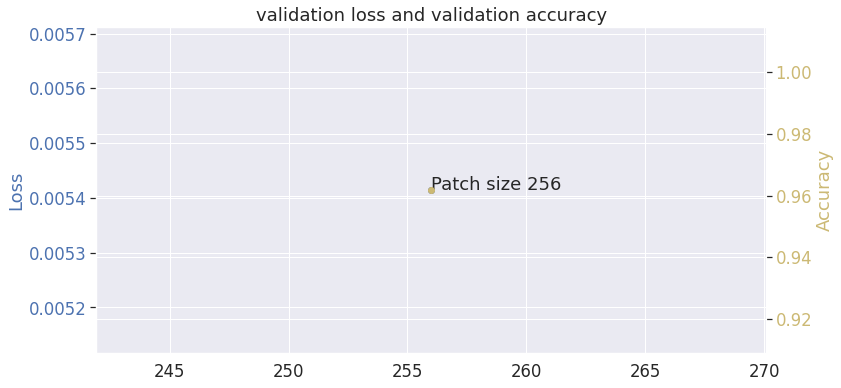

In [27]:
patch_sizes = list(plot_loss.keys())
loss = []
acc = []
for i in patch_sizes:
  loss.append(plot_test_loss[i]) 
  acc.append(plot_test_acc[i])


plot_test_loss_acc_patch_size(patch_sizes, loss, acc)

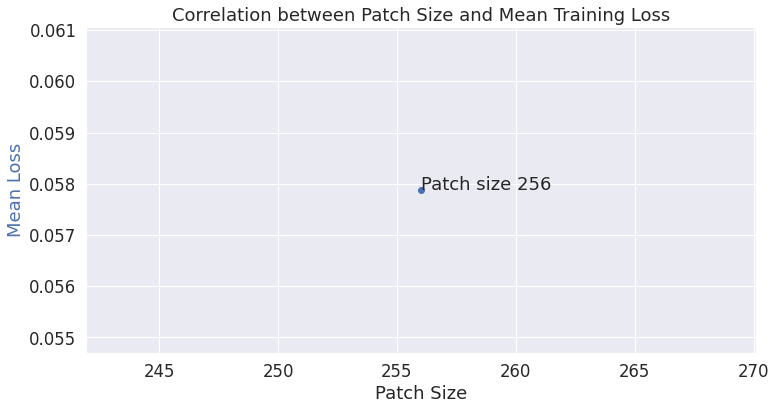

In [28]:


patch_sizes = list(plot_loss.keys())
loss = []
for i in patch_sizes:
  loss.append(sum((list(zip(*plot_loss[i]))[1])) / len((list(zip(*plot_loss[i]))[1])))

plot_loss_patch_size(patch_sizes, loss)

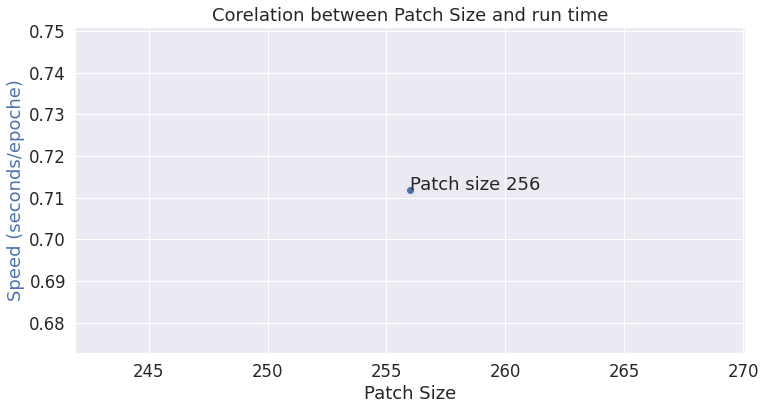

In [29]:

patch_sizes = list(plot_time.keys())
time = []
for i in patch_sizes:
  time.append(sum((list(zip(*plot_time[i]))[1])) / len((list(zip(*plot_time[i]))[1])))

plot_time_patch_size(patch_sizes, time)

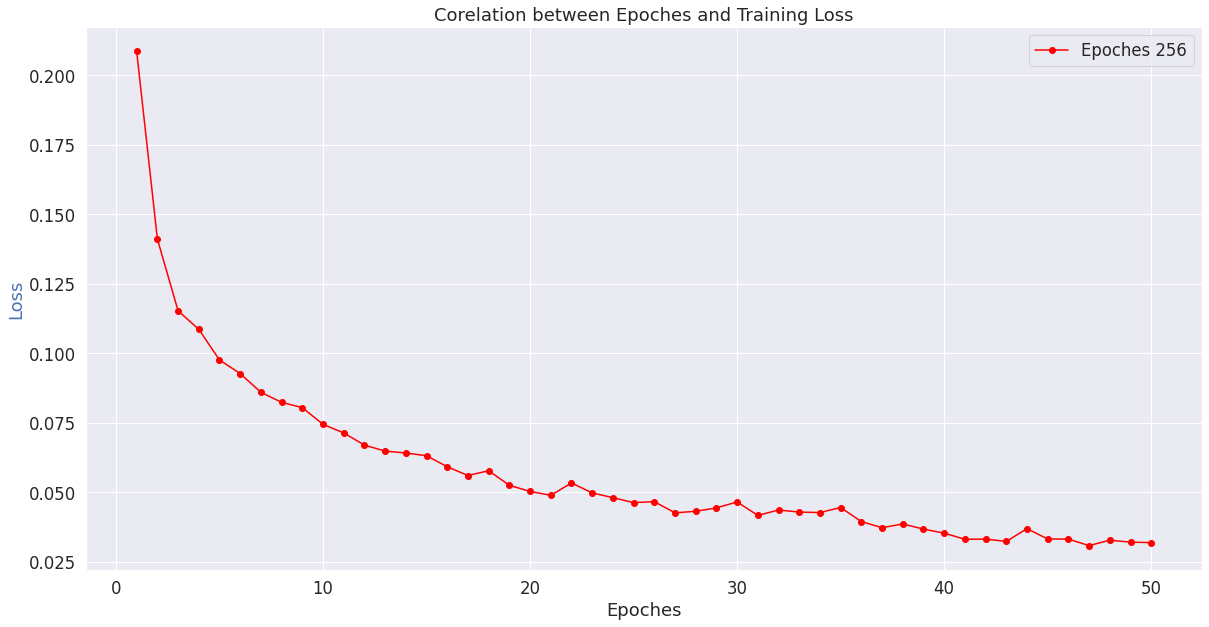

In [32]:
patch_sizes = list(plot_loss.keys())
plot_loss_epoches_patch_size(patch_sizes, plot_loss)

##test on animal and person dataset

Change directory name in validation to image, alpha, trimap

In [103]:

args["testDir"] = "/content/P3M-500-P"
args["testList"] = "/content/P3M-500-P/P3M-last-50-P_list.txt"
animal_loss = {}
animal_acc = {}
for i in range(len(patch_sizes)):
  args["patch_size"] = 256
  args["saveDir"] = store_model[i]
  args["model"] = models[i]
  animal_loss[patch_sizes[i]], animal_acc[patch_sizes[i]] = test(args, model)



Loading model from /content/ckpt1/human_matting/model/model_obj.pth...
Loading datasets ...
Dataset : file number 50


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AAAAA
sum:  tensor(63229.)
num:  65536
correct:  tensor(0.9648)
Test set results: loss= 0.02900 accuracy= 0.96480
AAAAA


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


sum:  tensor(61144.)
num:  65536
correct:  tensor(0.9330)
Test set results: loss= 0.03514 accuracy= 0.94889
AAAAA
sum:  tensor(60129.)
num:  65536
correct:  tensor(0.9175)
Test set results: loss= 0.02546 accuracy= 0.93843
AAAAA
sum:  tensor(64267.)
num:  65536
correct:  tensor(0.9806)
Test set results: loss= 0.01116 accuracy= 0.94898
AAAAA
sum:  tensor(64667.)
num:  65536
correct:  tensor(0.9867)
Test set results: loss= 0.00482 accuracy= 0.95653
AAAAA
sum:  tensor(59811.)
num:  65536
correct:  tensor(0.9126)
Test set results: loss= 0.00917 accuracy= 0.94922
AAAAA
sum:  tensor(61214.)
num:  65536
correct:  tensor(0.9341)
Test set results: loss= 0.00458 accuracy= 0.94705
AAAAA
sum:  tensor(61928.)
num:  65536
correct:  tensor(0.9449)
Test set results: loss= 0.00617 accuracy= 0.94679
AAAAA
sum:  tensor(63794.)
num:  65536
correct:  tensor(0.9734)
Test set results: loss= 0.00282 accuracy= 0.94975
AAAAA
sum:  tensor(64546.)
num:  65536
correct:  tensor(0.9849)
Test set results: loss= 0.0015

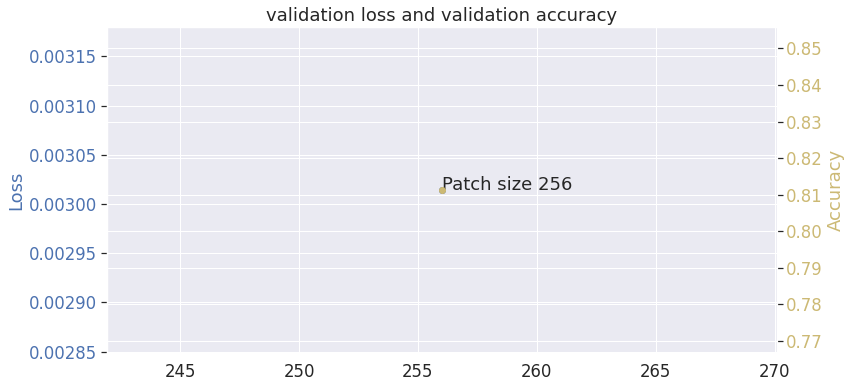

In [35]:
loss_a = []
acc_a = []
for i in patch_sizes:
  loss_a.append(animal_loss[i]) 
  acc_a.append(animal_acc[i])
plot_test_loss_acc_patch_size(patch_sizes, loss_a, acc_a)

Text(0.5, 1.0, 'Accuracy')

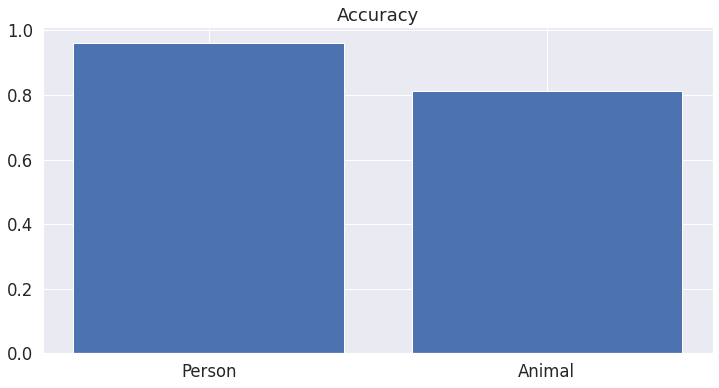

In [36]:
data = {}
data['Person'] = sum(plot_test_acc.values()) / len(plot_test_acc.values())
data['Animal'] = sum(animal_acc.values()) / len(animal_acc.values())
plt.bar(data.keys(), data.values())
plt.title('Accuracy')